# readme
descrip: plot to compare volume transports along the Florida Strait between CESM-POP diagnostics outputs and my own calculation by postprocessing CESM-POP output UVEL <br>

update history: <br>
v1.0 DL 2021Oct20 <br>
v1.1 DL 2021Oct22 correct for partial bottom cell following Steve's POP_MOC (https://github.com/sgyeager/POP_MOC/blob/main/pop_moc_0p1deg.py)<br>
v1.2 DL 2021Oct24 compare with CESM-POP diagnostics outputs <br>

extra notes: <br>
CESM-POP subroutine diag_transport line# 2010-2255 at https://github.com/ESCOMP/POP2-CESM/blob/master/source/diagnostics.F90 <br>
Channel index (https://ncar.github.io/POP/doc/build/html/users_guide/model-diagnostics-and-output.html) <br>

# import modules

In [1]:
# general python packages
import numpy as np
# from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
# import cartopy
# import cartopy.crs as ccrs
# cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob
import cftime
import util

# python GCM(POP) packages
# import xgcm
# import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.1.125:42266")
client

<Client: 'tcp://10.73.1.125:42266' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === t12 ===
# FSm: Florida Strait Meridional section
# 292  292 1418 1443    1   42 merid  Florida Strait 
# reference: https://ncar.github.io/POP/doc/build/html/users_guide/model-diagnostics-and-output.html
ilon1_FSm_t12 = 292-1 
ilat1_FSm_t12, ilat2_FSm_t12 = 1418-1-1, 1443 
# -1 is because python index starts from 0 while Fortran index starts from 1
# CESM-POP subroutine diag_transport line # 2010-2255 at https://github.com/ESCOMP/POP2-CESM/blob/master/source/diagnostics.F90
# compute averages along nlat dim, so I read one point ahead of 1418, the two sides are on the lands (KMU=0, see codes below)
# ===========

# read files

In [4]:
# CESM-POP UVEL HR
infile_uvel= ('/ihesp/archive/BHIST_1920-2100/b.e13.BHISTC5.ne120_t12.cesm-ihesp-hires1.0.30-1920-2100.002/tseries/ocn/'
              'to_archive/b.e13.BHISTC5.ne120_t12.cesm-ihesp-hires1.0.30-1920-2100.002.pop.h.UVEL.192001-200512.nc')

ds_uvel = xr.open_dataset(infile_uvel, chunks={'time':12})
ds_uvel

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1032, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time                (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    UVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 62, 2400, 3600), meta=np.ndarray>
Attributes:
    title:         b.e13.BHISTC5.ne120_t12.cesm-ihesp-hires1.0.30-1920-2100.002
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-11-06 at 11:00:43.3
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  19331
    tavg_sum:      2676600.0

In [5]:
# CESM-POP diagnostic transport (dt)
infile_dt = ('/ihesp/archive/BHIST_1920-2100/b.e13.BHISTC5.ne120_t12.cesm-ihesp-hires1.0.30-1920-2100.002/ocn/hist/'
             'b.e13.BHISTC5.ne120_t12.cesm-ihesp-hires1.0.30-1920-2100.002.pop.dt.2002-01-01-00000')
colnames=['time', 'Qv', 'Qh', 'Qs','channel_name'] 
df = pd.read_csv(infile_dt, sep='  ', engine='python',  usecols=[0,1,2,3,4], 
                header=None, skiprows=[0], names=colnames, index_col=[0]) 
df

,Qv,Qh,Qs,channel_name
time,,,,
29931.0,142.426100,1.720603,4894.309000,ACC-Drake
29931.0,23.556470,2.012000,852.275900,Florida Strait
29931.0,19.241530,1.769075,696.531600,Yucatan Passage (Zonal)
29931.0,-0.668173,-0.118708,-25.216260,Yucatan Passage (Merid)
29931.0,-7.829807,-0.608366,-281.971100,Jamaica Channel
...,...,...,...,...
31390.0,1.302303,0.112822,44.203830,Ohsumi Strait
31390.0,0.785523,0.064689,26.581150,Southern Korea Strait
31390.0,1.115963,0.079158,36.595320,Northern Korea Strait


# data analysis

In [6]:
# Compute 3D DZU with partial bottom cell corrected, copied from Steve Yegare's github 
# (https://github.com/sgyeager/POP_MOC/blob/main/pop_moc_0p1deg.py) 
# and commented a few lines. Need a POP history file for 3D DZU
in_file = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
              'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')

ds = xr.open_dataset(in_file)
pd     = ds['PD']
pd=pd.drop(['ULAT','ULONG'])            # this is a python bug that we are correcting
temp   = ds['TEMP']
temp=temp.drop(['ULAT','ULONG'])
# salt   = ds['SALT']
# salt=salt.drop(['ULAT','ULONG'])
# u_e   = ds['UVEL']/100
# u_e=u_e.drop(['TLAT','TLONG'])
# u_e.attrs['units']='m/s'
# v_e   = ds['VVEL']/100
# v_e=v_e.drop(['TLAT','TLONG'])
# v_e.attrs['units']='m/s'
# w_e   = ds['WVEL']/100
# w_e=w_e.drop(['ULAT','ULONG'])
# w_e.attrs['units']='m/s'
ulat   = ds['ULAT']
ulon   = ds['ULONG']
tlat   = ds['TLAT']
tlon   = ds['TLONG']
kmt  = ds['KMT']
kmt.values[np.isnan(kmt.values)]=0	# get rid of _FillValues
kmu  = ds['KMU']
kmu.values[np.isnan(kmu.values)]=0	# get rid of _FillValues
dxu    = ds['DXU']/100
dxu.attrs['units']='m'
dyu    = ds['DYU']/100
dyu.attrs['units']='m'
rmask  = ds['REGION_MASK']
tarea  = ds['TAREA']/100/100
tarea.attrs['units']='m^2'
uarea  = ds['UAREA']/100/100
uarea.attrs['units']='m^2'
time   = ds['time']
time.encoding['_FillValue']=None    
z_t   = ds['z_t']/100
z_t.attrs['units']='m'
z_w   = ds['z_w']/100
z_w.attrs['units']='m'
z_w_bot   = ds['z_w_bot']/100
z_w_bot.attrs['units']='m'
dz   = ds['dz']/100
dz.attrs['units']='m'
dzw   = ds['dzw']/100
dzw.attrs['units']='m'
hu   = ds['HU']/100
hu.attrs['units']='m'
ht   = ds['HT']/100
ht.attrs['units']='m'
dims = np.shape(temp)
nt = dims[0]
nz = dims[1]
ny = dims[2]
nx = dims[3]
km = int(np.max(kmt).values)
mval=pd.encoding['_FillValue']

# Create a k-index array for masking purposes
kji = np.indices((nz,ny,nx))
kindices = kji[0,:,:,:] + 1

# Define top/bottom depths of POP T-grid
z_bot=z_w.values
z_bot=z_w.values+dz.values
z_top=z_w.values

# Compute PBC from grid info:
dzt = util.pbc_dzt(dz,kmt,ht,z_w_bot,mval)

# Regrid PBC thicknesses to U-grid
tmp=dzt
tmpe=tmp.roll(nlon=-1,roll_coords=False)        # wraparound shift to west, without changing coords
tmpn=tmp.shift(nlat=-1)                         # shift to south, without changing coords
tmpne=tmpn.roll(nlon=-1,roll_coords=False)      # wraparound shift to west, without changing coords
tmpall=xr.concat([tmp,tmpe,tmpn,tmpne],dim='dummy')
dzu=tmpall.min('dummy')
dzu.attrs['units'] = 'm'
del tmp,tmpe,tmpn,tmpne,tmpall

dzu # 3D DZU with partial bottom cell corrected

<xarray.DataArray (z_t: 62, nlat: 2400, nlon: 3600)>
array([[[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        ...,
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36]],

       [[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
...
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36]],

       [[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        ...,
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36]]])
Dimensions without coordinates: z_t, nlat, nlon
Attributes:
    units:    m

In [7]:
# compute kmu
kmu_FSm = ds_uvel.KMU.isel(nlon=ilon1_FSm_t12, 
                           nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12)).values
kmu_FSm # two sides are land points, kMU=0

array([ 0.,  0.,  0.,  3.,  3., 28., 39., 41., 41., 41., 42., 41., 40.,
       39., 38., 36., 29., 23., 19., 12.,  3.,  3.,  3.,  3.,  3.,  0.,
        0.])

In [8]:
# compute dyu
dyu_FSm = ds_uvel.DYU.isel(nlon=ilon1_FSm_t12, 
                           nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12)).values/100 # unit: m 
dyu_FSm

array([10247.14164119, 10240.1905632 , 10233.21772814, 10226.22322298,
       10219.20713439, 10212.16954911, 10205.11055467, 10198.03023846,
       10190.92868756, 10183.80598958, 10176.66223205, 10169.4975026 ,
       10162.31188918, 10155.10547988, 10147.87836248, 10140.63062509,
       10133.36235593, 10126.07364337, 10118.76457569, 10111.43524151,
       10104.08572937, 10096.71612772, 10089.32652538, 10081.91701129,
       10074.48767435, 10067.0386031 , 10059.56988696])

In [9]:
# compute dzu
dzu_FSm = dzu.isel(nlon=ilon1_FSm_t12, 
                   nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12))
dzu_FSm

<xarray.DataArray (z_t: 62, nlat: 27)>
array([[9.96920997e+36, 9.96920997e+36, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 1.00000000e+01, ...,
        1.00000000e+01, 1.00000000e+01, 9.96920997e+36],
       ...,
       [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
        9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
        9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
        9.96920997e+36, 9.96920997e+36, 9.96920997e+36]])
Dimensions without coordinates: z_t, nlat
Attributes:
    units:    m

CPU times: user 133 ms, sys: 25.7 ms, total: 159 ms
Wall time: 19.4 s


<xarray.DataArray 'UVEL' (z_t: 62, nlat: 27)>
array([[     nan,      nan,      nan, ..., 9.332577,      nan,      nan],
       [     nan,      nan,      nan, ..., 9.26129 ,      nan,      nan],
       [     nan,      nan,      nan, ..., 8.886585,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat) float64 -80.8 -80.8 -80.8 -80.8 ... -80.8 -80.8 -80.8 -80.8
    ULAT     (nlat) float64 22.87 22.96 23.06 23.15 ... 24.97 25.06 25.16 25.25
    TLONG    (nlat) float64 279.1 279.1 279.1 279.1 ... 279.1 279.1 279.1 279.1
    TLAT     (nlat) float64 22.83 22.92 23.01 23.1 ... 24.93 25.02 25.11 25.2
    time     object 1920-02-01 00:00:00
Dimensions without coordinates: nlat
Attributes:
    long_name:     Velocity in grid-x direction
    units:         centimeter/s
    grid_loc:      3221
    cell_methods:  time: mean

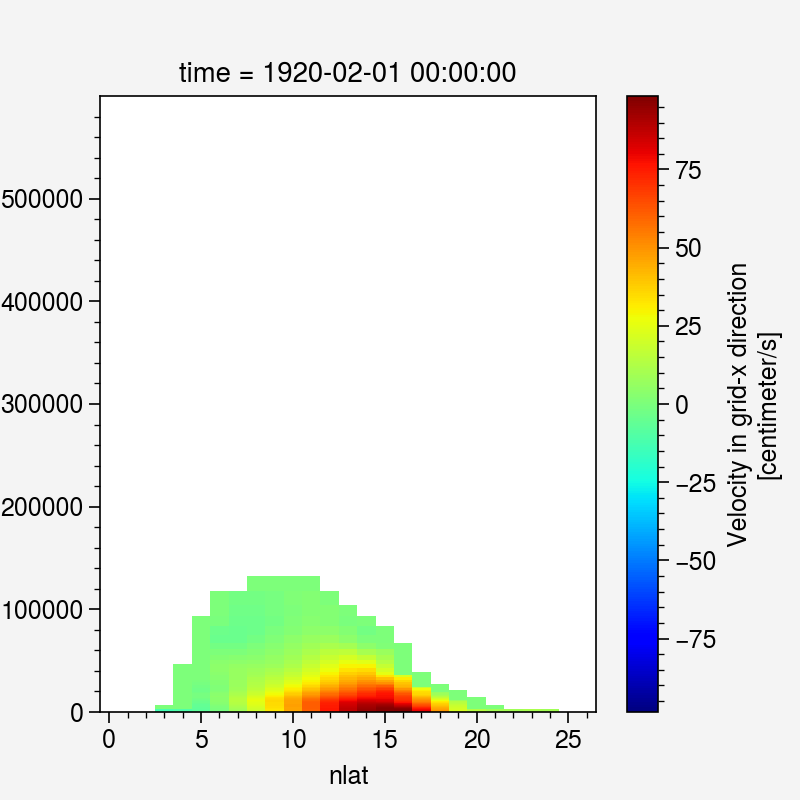

In [10]:
%%time
u_FSm = ds_uvel.UVEL.isel(nlon=ilon1_FSm_t12, nlat=slice(ilat1_FSm_t12, ilat2_FSm_t12)
                    ).compute().where(kmu_FSm>0, np.nan) # mask land points 
u_FSm.isel(time=0).plot(cmap='jet') # land points are nan
u_FSm.isel(time=0)

In [11]:
um_FSm = u_FSm.fillna(0)/100 # fill land with 0 before computing sum
Q_FSm = um_FSm*dyu_FSm*dzu_FSm # Q is flux
Q_FSm

<xarray.DataArray (time: 1032, z_t: 62, nlat: 27)>
array([[[    0.        ,     0.        ,     0.        , ...,
          9402.09258521,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
          9330.27442862,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
          8952.77949242,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]],

       [[    0.        ,     0.        ,     0.        , ...,
          7419.7208089 ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
          8361.77040769,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
          8197.09755963,     0.        ,     0.        ],
...
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]],

       [[    0.        ,     0.        ,     0.        , ...,
          8288.6379368 ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
         10661.78740534,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
         13714.13337064,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]]])
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat) float64 -80.8 -80.8 -80.8 -80.8 ... -80.8 -80.8 -80.8 -80.8
    ULAT     (nlat) float64 22.87 22.96 23.06 23.15 ... 24.97 25.06 25.16 25.25
    TLONG    (nlat) float64 279.1 279.1 279.1 279.1 ... 279.1 279.1 279.1 279.1
    TLAT     (nlat) float64 22.83 22.92 23.01 23.1 ... 24.93 25.02 25.11 25.2
  * time     (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:00:00
Dimensions without coordinates: nlat

<xarray.DataArray (time: 1032)>
array([22.49622645, 25.1427153 , 25.39856726, ..., 20.82314967,
       22.75212277, 26.34600576])
Coordinates:
  * time     (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:00:00

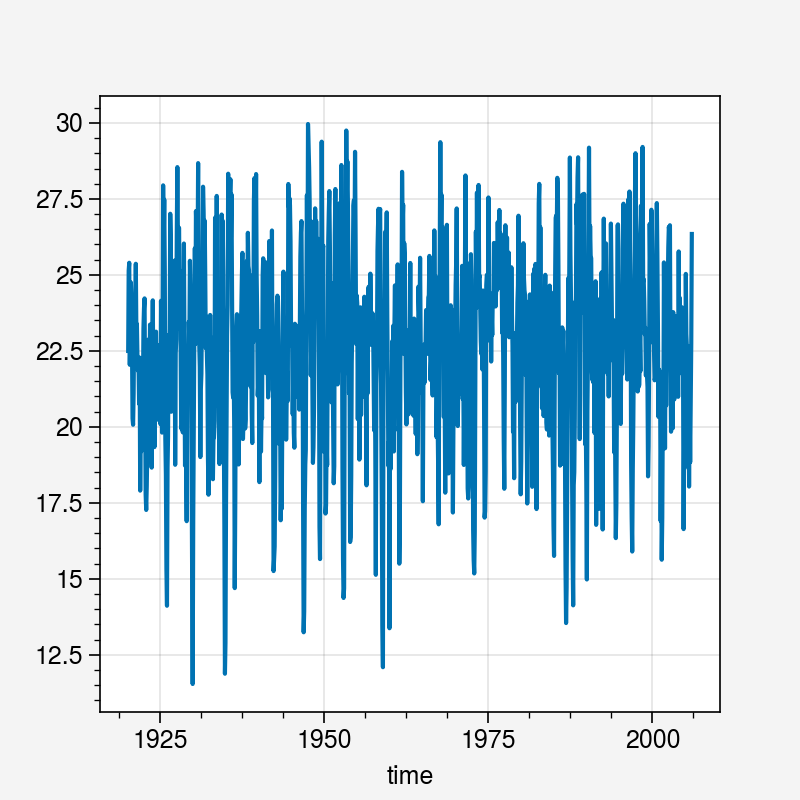

In [12]:
Q_FSm_av = (Q_FSm[:,:,0:-1] + Q_FSm[:,:,1:])/2
# compute mean along nlat dim following line 2103-2109 at https://github.com/ESCOMP/POP2-CESM/blob/master/source/diagnostics.F90
Q_FSm_sum = Q_FSm_av.sum(('z_t','nlat'))/1e6 # convert unit to Sv
Q_FSm_sum.plot()
Q_FSm_sum

In [13]:
nchannel = 141
ds1_FSm = df.iloc[1::nchannel,:].to_xarray() # Florida Strait
ds1_FSm

<xarray.Dataset>
Dimensions:       (time: 1460)
Coordinates:
  * time          (time) float64 2.993e+04 2.993e+04 ... 3.139e+04 3.139e+04
Data variables:
    Qv            (time) float64 23.56 24.68 24.29 23.25 ... 28.99 28.25 27.2
    Qh            (time) float64 2.012 2.123 2.117 2.038 ... 2.423 2.388 2.303
    Qs            (time) float64 852.3 892.7 879.4 ... 1.051e+03 1.025e+03 986.4
    channel_name  (time) object 'Florida Strait' ... 'Florida Strait'

In [14]:
time1 = cftime.num2date(ds1_FSm.time, units='days since 1919-12-31 00:00:00', calendar='noleap')
time1
ds1_FSm = ds1_FSm.assign_coords(time=time1) #.resample(time='A').mean()
ds1_FSm 

<xarray.Dataset>
Dimensions:       (time: 1460)
Coordinates:
  * time          (time) object 2002-01-01 00:00:00 ... 2005-12-31 00:00:00
Data variables:
    Qv            (time) float64 23.56 24.68 24.29 23.25 ... 28.99 28.25 27.2
    Qh            (time) float64 2.012 2.123 2.117 2.038 ... 2.423 2.388 2.303
    Qs            (time) float64 852.3 892.7 879.4 ... 1.051e+03 1.025e+03 986.4
    channel_name  (time) object 'Florida Strait' ... 'Florida Strait'

# make pics

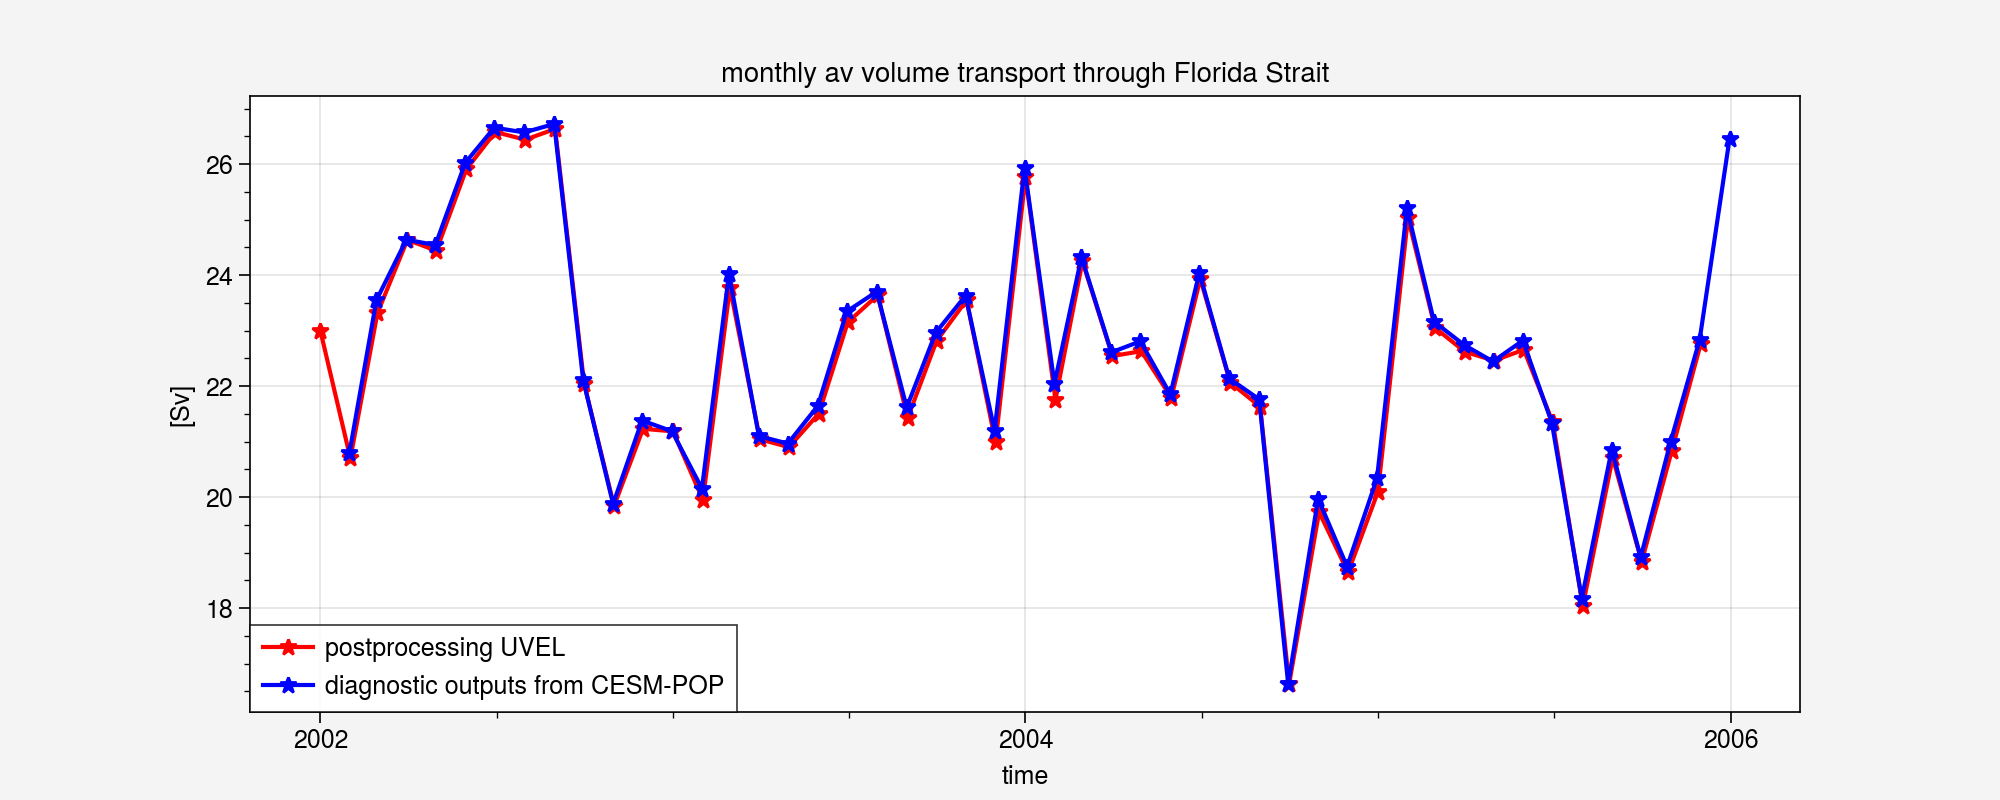

In [15]:
# compare my postprocessing codes with CESM-POP diagnostics outputs
fig1, axs = plt.subplots(1,1, figsize=(10,4))

Q_FSm_sum.sel(time=slice('2002','2005')).plot(ax=axs, color='r', label='postprocessing UVEL',marker='*')
ds1_FSm.Qv.resample(time='M').mean().plot(ax=axs, color='b', label='diagnostic outputs from CESM-POP',marker='*')
axs.legend()
axs.set_title('monthly av volume transport through Florida Strait')
axs.set_ylabel('[Sv]')

fig1.savefig('CompareVolumeTransportFloridaStraitCESM.png', bbox_inches='tight')